# Crime and Parks

For our final project we wanted to know whether areas with more parks had less crime than areas with fewer or no parks.

In order to investigate this question we decided to look at crime and park data from 5 major cities: New York City, Chicago, Philadelphia, Boston, and San Francisco. Because we are looking at a geographic connection, we decided to look at only one year at a time. We initially looked only at the year 2016.

For data we will use:

* Park or "Open Space" data or shapefiles from:
  * New York City: https://data.cityofnewyork.us/Recreation/Open-Space-Parks-/g84h-jbjm
  * Chicago: https://dev.socrata.com/foundry/data.cityofchicago.org/ejsh-fztr
  * Philadelphia: https://www.opendataphilly.org/dataset/parks-and-recreation-assets
  * Boston: https://data.boston.gov/dataset/open-space
  * San Francisco: https://data.sfgov.org/Culture-and-Recreation/Park-and-Open-Space-Map/4udc-s3pr


* Common geographical areas from:
  * New York City: https://dev.socrata.com/foundry/data.cityofnewyork.us/kmub-vria
  * Chicago: https://dev.socrata.com/foundry/data.cityofchicago.org/igwz-8jzy
  * Philadelphia: https://www.opendataphilly.org/dataset/police-districts
  *               https://services.arcgis.com/fLeGjb7u4uXqeF9q/arcgis/rest/services/Boundaries_District/FeatureServer/0/query?outFields=*&where=1%3D1
  * Boston: http://bostonopendata-boston.opendata.arcgis.com/datasets/9a3a8c427add450eaf45a470245680fc_5.zip (Shape file, not a landing page)
  * San Francisco: https://dev.socrata.com/foundry/data.sfgov.org/q52f-skbd
  

* Crime APIs and data from:
  * New York City: https://dev.socrata.com/foundry/data.cityofnewyork.us/9s4h-37hy
  * Chicago: https://dev.socrata.com/foundry/data.cityofchicago.org/6zsd-86xi
  * Philadelphia: https://cityofphiladelphia.github.io/carto-api-explorer/#incidents_part1_part2
  * Boston: https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system
  * San Francisco: https://dev.socrata.com/foundry/data.sfgov.org/cuks-n6tp

Boston does not have an API interface, so we will instead download the csv directly. Luckily Boston switched from an old system to a new system, so the csv file we are interested in only has data from August 2015 to present, which will make it less arduous to download and work with.

In [319]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import shape
from shapely.geometry import Point


import requests, json

import pandas as pd
import seaborn as sns
sns.set_style({"axes.grid": "False"}, {'axes.axisbelow': "False"})
sns.set_style({"axes.linewidth": 0})

import pytz
import datetime

from urllib.parse import quote

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.regression.mixed_linear_model as sm_mlm

from time import sleep

### Chicago

We will acquire the data for crime in Chicago similarly to how we did in class for the Weather and Crime example.

In [320]:
soql = "https://data.cityofchicago.org/resource/6zsd-86xi.json?$query="
soql += quote("SELECT id, community_area, primary_type ")
soql += quote("WHERE year == 2016 ")
soql += quote("LIMIT 300000")

resp = requests.get(soql).json()
chicago_crime = pd.DataFrame(resp)
chi_CA_count = chicago_crime.groupby("community_area").count()

In [321]:
soql = "https://data.cityofchicago.org/resource/igwz-8jzy.json?$query="
soql += quote("SELECT area_numbe as Number, community, the_geom ")
soql += quote("LIMIT 300000")

resp = requests.get(soql).json()

Because the data is downloaded as a json object, and thus parsed as a dictionary, we must convert it into geopandas data frame. 

In [322]:
data = resp
for d in data:
    d['the_geom'] = shape(d['the_geom'])

chicago_comm_areas = gpd.GeoDataFrame(data).set_geometry('the_geom')
chicago_comm_areas.crs = {'init' :'epsg:4269'}
chicago_comm_areas.head()

,Number,community,the_geom
0,35,DOUGLAS,(POLYGON ((-87.60914087617894 41.8446925026539...
1,36,OAKLAND,(POLYGON ((-87.59215283879394 41.8169293462668...
2,37,FULLER PARK,(POLYGON ((-87.62879823733725 41.8018930336891...
3,38,GRAND BOULEVARD,(POLYGON ((-87.6067081256125 41.81681377057218...
4,39,KENWOOD,(POLYGON ((-87.59215283879394 41.8169293462668...


In [323]:
chi_CA_count = chi_CA_count.reset_index()
chicago_comm_areas = chicago_comm_areas.merge(chi_CA_count, left_on = 'Number', right_on = 'community_area')

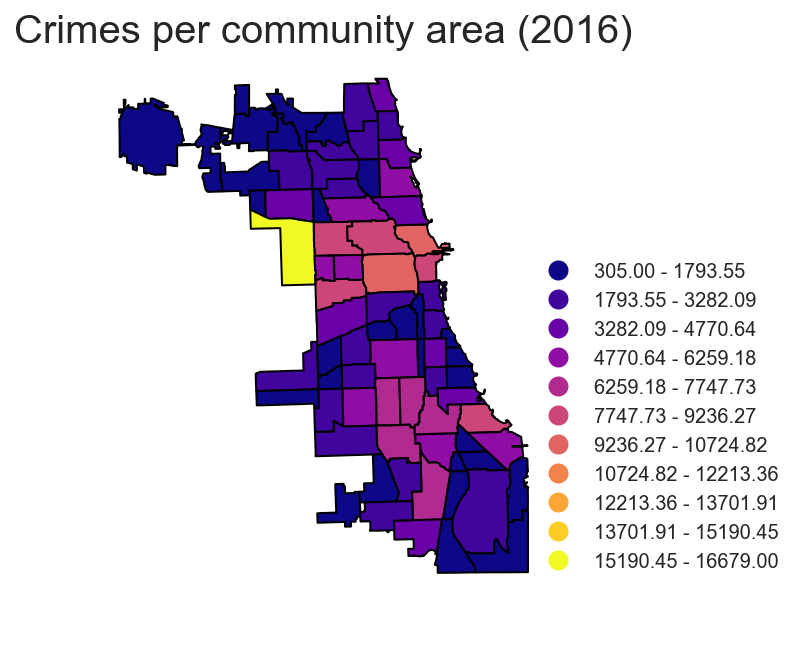

In [324]:
CAMap = chicago_comm_areas.to_crs(epsg = 3528).plot(column = 'id', scheme = 'equal_interval', k = 11, cmap = 'plasma', legend=True,
                               linewidth = 1, edgecolor = 'black', figsize = (9,5))
CAMap.set_title("Crimes per community area (2016)", fontsize = 20)
CAMap.set_axis_off()
CAMap.get_legend().set_bbox_to_anchor((1.55, .65))
CAMap.get_legend().get_frame().set_linewidth(0)

In [325]:
chi_CA_count.set_index('community_area', inplace = True)

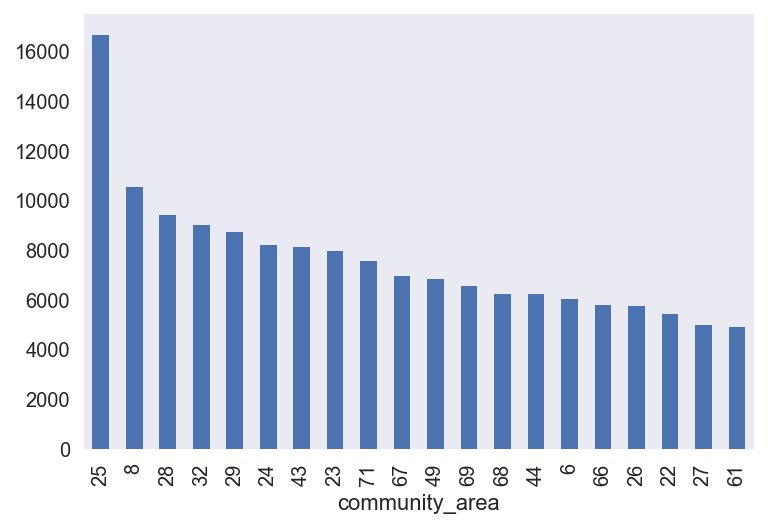

In [326]:
chi_CA_count.sort_values('id', ascending = False)['id'].head(20).plot.bar()

So community area 25 is by far the highest total amount of crime in 2016.

In [327]:
CAPop = pd.read_csv("CAPop.csv", dtype={'Community Area': str})

In [328]:
chicago_comm_areas = chicago_comm_areas.merge(CAPop, left_on = "community_area", right_on = "Community Area")

In [329]:
chicago_comm_areas.head()

,Number,community,the_geom,community_area,id,primary_type,Community Area,Population
0,35,DOUGLAS,(POLYGON ((-87.60914087617894 41.8446925026539...,35,2597,2597,35,18238
1,36,OAKLAND,(POLYGON ((-87.59215283879394 41.8169293462668...,36,698,698,36,5918
2,37,FULLER PARK,(POLYGON ((-87.62879823733725 41.8018930336891...,37,925,925,37,2876
3,38,GRAND BOULEVARD,(POLYGON ((-87.6067081256125 41.81681377057218...,38,3284,3284,38,21929
4,39,KENWOOD,(POLYGON ((-87.59215283879394 41.8169293462668...,39,1405,1405,39,17841


In [330]:
chicago_comm_areas['Crimes per person'] = chicago_comm_areas['id']/chicago_comm_areas['Population']

In [331]:
chicago_comm_areas.head()

,Number,community,the_geom,community_area,id,primary_type,Community Area,Population,Crimes per person
0,35,DOUGLAS,(POLYGON ((-87.60914087617894 41.8446925026539...,35,2597,2597,35,18238,0.142395
1,36,OAKLAND,(POLYGON ((-87.59215283879394 41.8169293462668...,36,698,698,36,5918,0.117945
2,37,FULLER PARK,(POLYGON ((-87.62879823733725 41.8018930336891...,37,925,925,37,2876,0.321627
3,38,GRAND BOULEVARD,(POLYGON ((-87.6067081256125 41.81681377057218...,38,3284,3284,38,21929,0.149756
4,39,KENWOOD,(POLYGON ((-87.59215283879394 41.8169293462668...,39,1405,1405,39,17841,0.078751


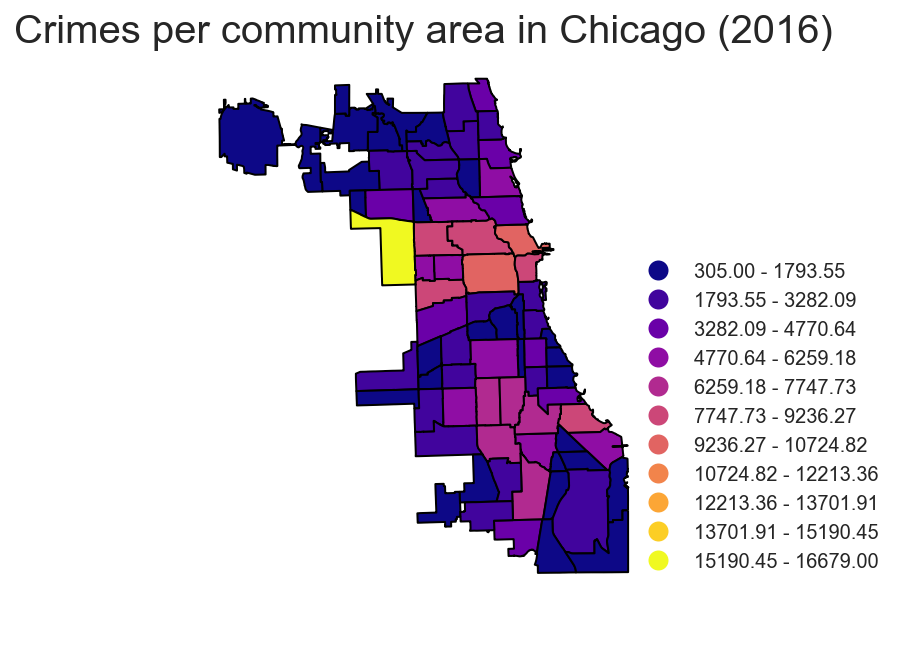

In [332]:
CAMap = chicago_comm_areas.to_crs(epsg = 3528).plot(column = 'id', scheme = 'equal_interval', k = 11, cmap = 'plasma', legend=True,
                               linewidth = 1, edgecolor = 'black', figsize = (9,5))
CAMap.set_title("Crimes per community area in Chicago (2016)", fontsize = 20)
CAMap.set_axis_off()
CAMap.get_legend().set_bbox_to_anchor((1.55, .65))
CAMap.get_legend().get_frame().set_linewidth(0)

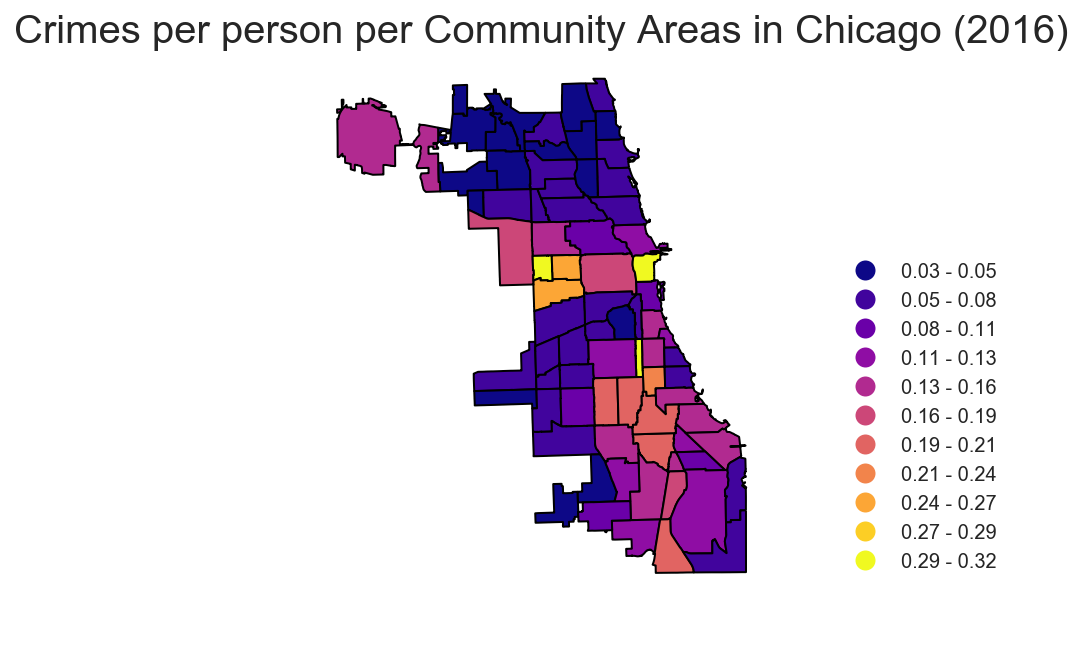

In [333]:
PerPerson = chicago_comm_areas.to_crs(epsg = 3528).plot(column = 'Crimes per person', scheme='equal_interval', k = 11, cmap = 'plasma', legend=True,
                                   linewidth = 1, edgecolor = 'black', figsize = (9,5))
PerPerson.set_title("Crimes per person per Community Areas in Chicago (2016)", fontsize = 20)
PerPerson.set_axis_off()

PerPerson.get_legend().set_bbox_to_anchor((1.55, .65))
PerPerson.get_legend().get_frame().set_linewidth(0)

The map looks slightly different now that we adjusted for population in the community areas.

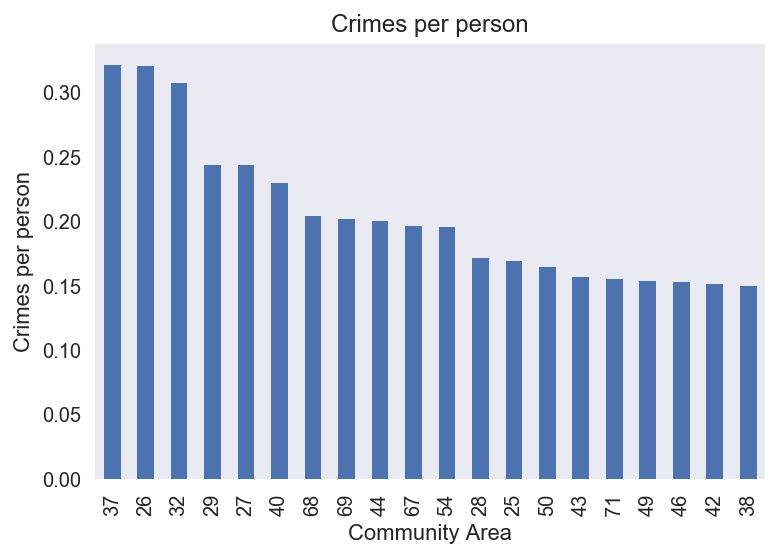

In [334]:
CPP = chicago_comm_areas[['Number','Crimes per person']].sort_values('Crimes per person', ascending = False).head(20).plot.bar('Number', 'Crimes per person')
CPP.set_title("Crimes per person")
CPP.set_xlabel("Community Area")
CPP.set_ylabel("Crimes per person")
CPP.legend_.remove()

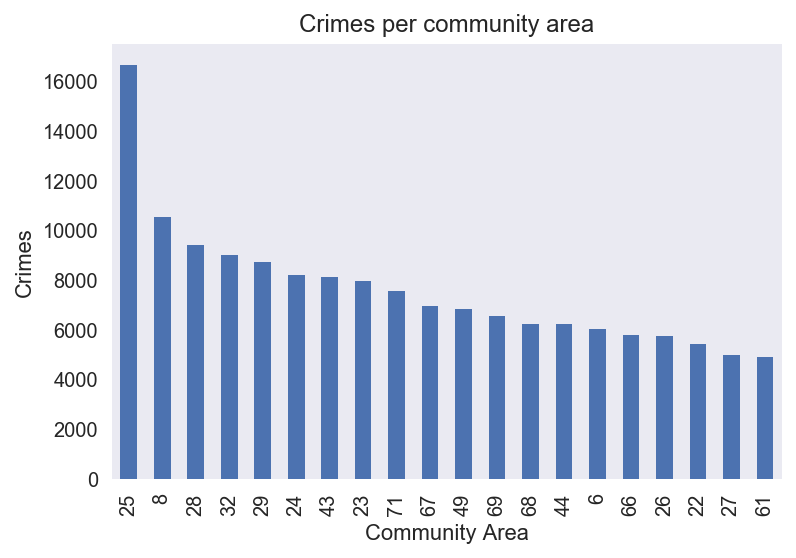

In [335]:
#chi_CA_count.set_index('community_area', inplace = True)
CCA = chi_CA_count.sort_values('id', ascending = False)['id'].head(20).plot.bar()
CCA.set_title("Crimes per community area")
CCA.set_xlabel("Community Area")
CCA.set_ylabel("Crimes")

Might be able to use community areas to define polygons, then take the api to only draw parks where the points are within the polygon. Need to parse data from community area polygons and SoQL query.

Full credit to Professor Saxon for providing cleaned geojson and the code to assess the park area and distance to a park from class. We attempted to download the data freshly ourselves from City of Chicago, but had trouble with projections aligning. The geodataframes were formatted in some way such that any analysis of buffers were being done in degrees, rather than km.

In [336]:
tracts = gpd.read_file("chicago_tracts.geojson").to_crs(epsg = 3528)
parks  = gpd.read_file("chicago_parks.geojson") .to_crs(epsg = 3528)

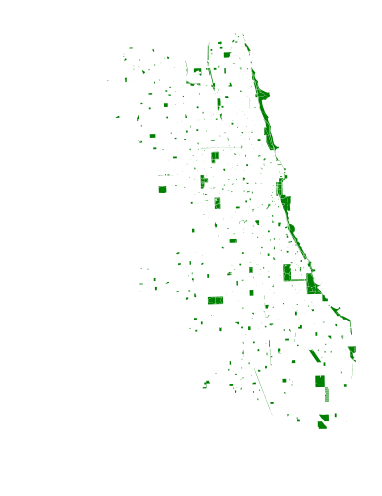

In [337]:
puu = parks.unary_union
tuu = tracts.unary_union

ax = parks.plot(color = "green")
ax.set_axis_off()
# ax.figure.savefig("individual_parks.pdf")

In [338]:
tracts["park_area"] = tracts.centroid.buffer(500).intersection(puu).area
tracts["distance"]  = tracts.centroid.distance(puu)

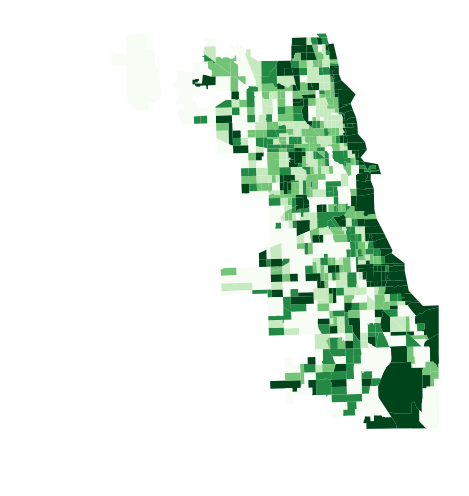

In [339]:
tracts.plot(column = "park_area", cmap = "Greens", scheme = "quantiles").set_axis_off()

I downloaded crime data from the past year as a geojson.

In [340]:
chicago_crimes = gpd.read_file("C:/Users/mjcor/Desktop/ippp-final-project/chicago_crimes.geojson").to_crs(epsg = 3528)

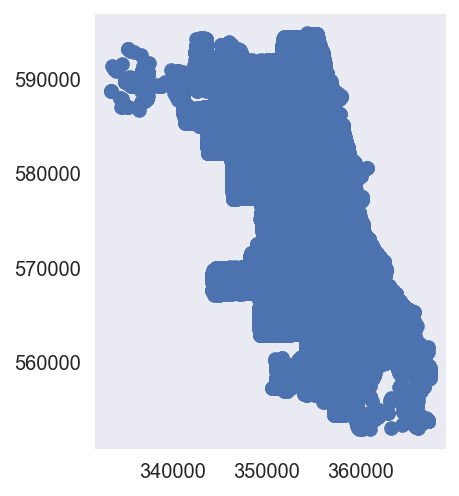

In [341]:
chicago_crimes.plot()

In [342]:
chicago_crimes.crs

{'init': 'epsg:3528', 'no_defs': True}

In [343]:
tracts.crs

{'init': 'epsg:3528', 'no_defs': True}

In [344]:
tract_crime_count = gpd.sjoin(chicago_crimes, tracts, how = 'left', op = 'within')

In [345]:
tract_crime_count.head()

,id,primary_type,geometry,index_right,statefp10,name10,commarea_n,namelsad10,commarea,geoid10,notes,tractce10,countyfp10,park_area,distance
0,10527059,WEAPONS VIOLATION,POINT (348726.9494546789 578884.0233997847),68.0,17,2522.02,25,Census Tract 2522.02,25,17031252202,,252202,031,7899.426804,232.882440
1,10489186,THEFT,POINT (358552.8066667992 579403.708394426),579.0,17,3201,32,Census Tract 3201,32,17031320100,,320100,031,138419.670022,102.737812
2,10657536,OFFENSE INVOLVING CHILDREN,POINT (351295.1993553095 580955.4482959368),422.0,17,2311,23,Census Tract 2311,23,17031231100,,231100,031,1312.526793,197.635613
3,10589724,CRIM SEXUAL ASSAULT,POINT (363359.2075362899 562066.6496971025),491.0,17,4804,48,Census Tract 4804,48,17031480400,,480400,031,0.000000,561.500121
4,10596351,OFFENSE INVOLVING CHILDREN,POINT (357179.3751932773 565239.3192493721),571.0,17,7102,71,Census Tract 7102,71,17031710200,,710200,031,25879.091487,212.374118


In [346]:
count = tract_crime_count.groupby('namelsad10').count()['id']

In [347]:
count = pd.DataFrame(count)

In [348]:
count.head()

,id
namelsad10,
Census Tract 1001,177
Census Tract 1002,215
Census Tract 1003,150
Census Tract 1004,93
Census Tract 1005,208


In [349]:
crime_tracts = pd.merge(tracts, count, left_on = "namelsad10", right_index = True)

In [350]:
crime_tracts['Count'] = crime_tracts['id']

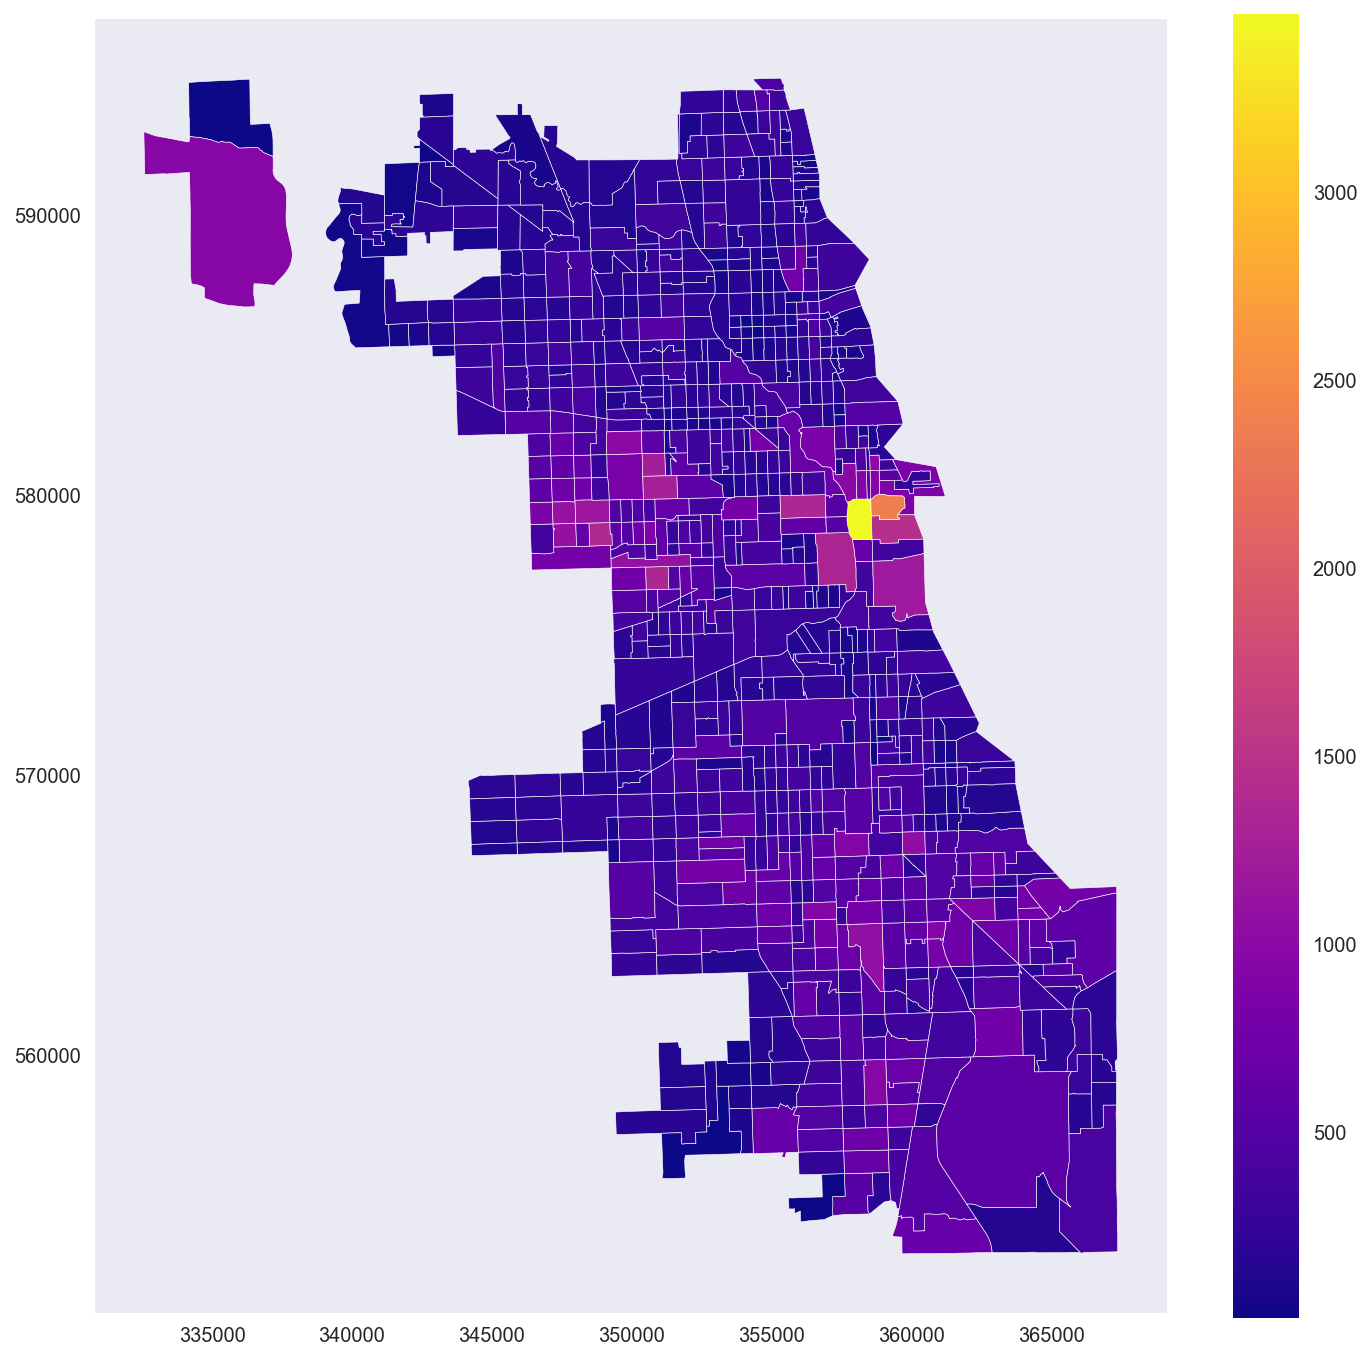

In [407]:
crime_tracts.plot(column = 'Count', cmap = 'plasma', edgecolor = 'white', legend = True, figsize = (12, 12))

In [352]:
crime_tracts.sort_values('namelsad10').head(100)

,statefp10,name10,commarea_n,namelsad10,commarea,geoid10,notes,tractce10,countyfp10,geometry,park_area,distance,id,Count
index_right,,,,,,,,,,,,,,
655,17,1001,10,Census Tract 1001,10,17031100100,,100100,031,(POLYGON ((345607.9216306749 591909.5485953798...,12851.410713,181.995944,177,177
656,17,1002,10,Census Tract 1002,10,17031100200,,100200,031,(POLYGON ((345223.6917729162 591588.4134620316...,9110.596279,341.954093,215,215
732,17,1003,10,Census Tract 1003,10,17031100300,,100300,031,(POLYGON ((343213.0299136328 590701.1679883189...,11177.385950,76.677247,150,150
733,17,1004,10,Census Tract 1004,10,17031100400,,100400,031,(POLYGON ((343213.0299136328 590701.1679883189...,0.000000,845.065946,93,93
734,17,1005,10,Census Tract 1005,10,17031100500,,100500,031,(POLYGON ((343620.8967614853 589692.8819405686...,68995.232413,290.139559,208,208
698,17,1006,10,Census Tract 1006,10,17031100600,,100600,031,(POLYGON ((343620.8392075102 589661.7806578649...,0.000000,730.503807,264,264
699,17,1007,10,Census Tract 1007,10,17031100700,,100700,031,"(POLYGON ((343997.2556540439 588717.635410215,...",0.000000,1102.357960,92,92
339,17,101,1,Census Tract 101,1,17031010100,,010100,031,(POLYGON ((355463.1823723586 594474.1220955061...,35550.031004,84.131070,439,439
51,17,102.01,1,Census Tract 102.01,1,17031010201,,010201,031,(POLYGON ((354109.4395123129 593701.6644246908...,44431.862249,106.354422,349,349


In [353]:
addr = 'https://api.census.gov/data/2015/acs/acs5?get=NAME,B01001_001E&for=tract:*&in=state:17&in=county:031'
resp = requests.get(addr)

In [354]:
json = resp.json()

In [355]:
pop = pd.DataFrame(json)

In [356]:
pop.head()

,0,1,2,3,4
0,NAME,B01001_001E,state,county,tract
1,"Census Tract 101, Cook County, Illinois",4106,17,031,010100
2,"Census Tract 102.01, Cook County, Illinois",7229,17,031,010201
3,"Census Tract 102.02, Cook County, Illinois",2304,17,031,010202
4,"Census Tract 103, Cook County, Illinois",6077,17,031,010300


In [357]:
pop.columns.values

array([0, 1, 2, 3, 4], dtype=int64)

In [358]:
pop.columns = pop.iloc[0]

In [359]:
pop = pop.drop(0)

In [360]:
pop['numeric'] = pd.to_numeric(pop['tract'])/100.0

In [361]:
crime_tracts['numeric'] = pd.to_numeric(crime_tracts['name10'])

In [362]:
crime_tracts.head()

,statefp10,name10,commarea_n,namelsad10,commarea,geoid10,notes,tractce10,countyfp10,geometry,park_area,distance,id,Count,numeric
index_right,,,,,,,,,,,,,,,
0,17,8424,44,Census Tract 8424,44,17031842400,,842400,031,(POLYGON ((359011.0918414976 562381.5134188498...,55851.593831,188.562540,1064,1064,8424.0
1,17,8403,59,Census Tract 8403,59,17031840300,,840300,031,(POLYGON ((353772.6046558226 572641.0855168948...,8148.527544,249.580478,234,234,8403.0
2,17,8411,34,Census Tract 8411,34,17031841100,,841100,031,(POLYGON ((358458.7375946075 575992.5376885971...,6642.280407,316.925605,423,423,8411.0
3,17,8412,31,Census Tract 8412,31,17031841200,,841200,031,(POLYGON ((353574.5667614859 576275.6182143808...,0.000000,615.512418,349,349,8412.0
4,17,8382,28,Census Tract 8382,28,17031838200,,838200,031,(POLYGON ((355245.5246228033 578342.4871348761...,3144.627241,449.379846,392,392,8382.0


In [363]:
merged = pd.merge(crime_tracts, pop, left_on = 'numeric', right_on = 'numeric')

In [364]:
merged = gpd.GeoDataFrame(merged)

C:\cygwin64\home\mjcor\Continuum\Anaconda3\lib\site-packages\matplotlib\colors.py:861: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
C:\cygwin64\home\mjcor\Continuum\Anaconda3\lib\site-packages\matplotlib\colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


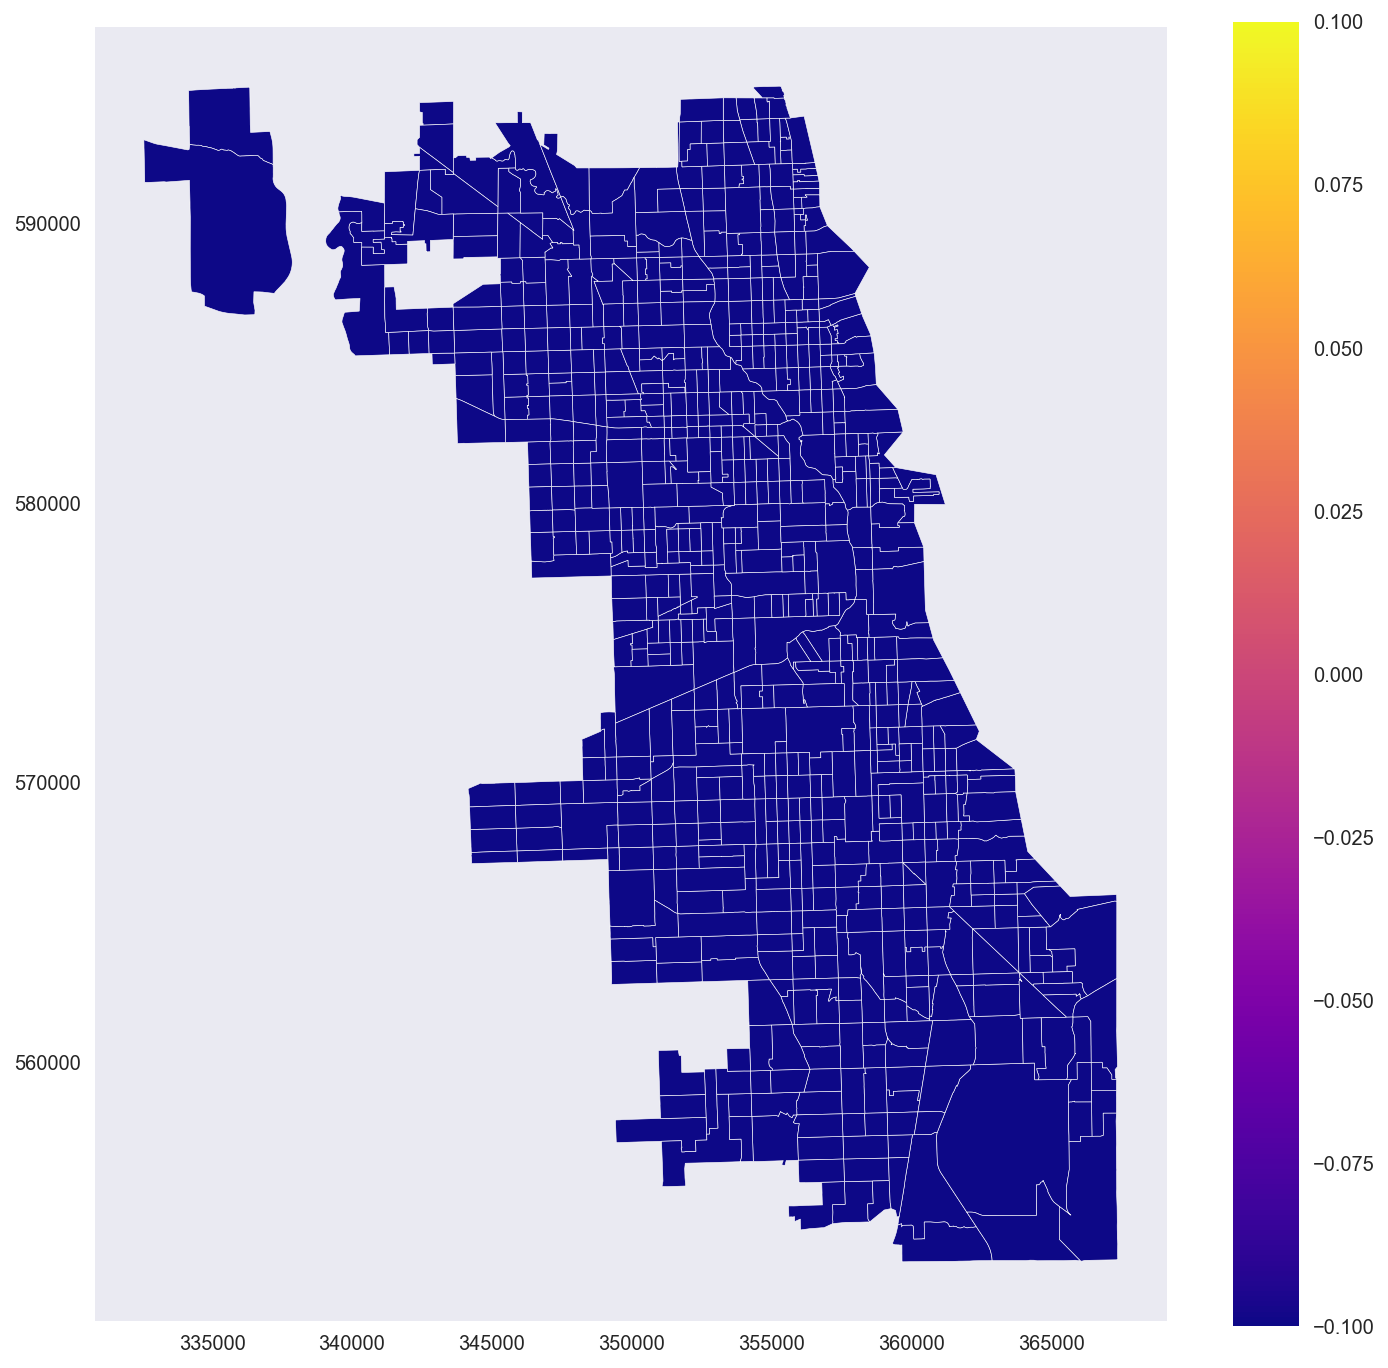

In [408]:
merged.plot(column = 'Count', cmap = 'plasma', edgecolor = 'white', legend = True, figsize = (12, 12))

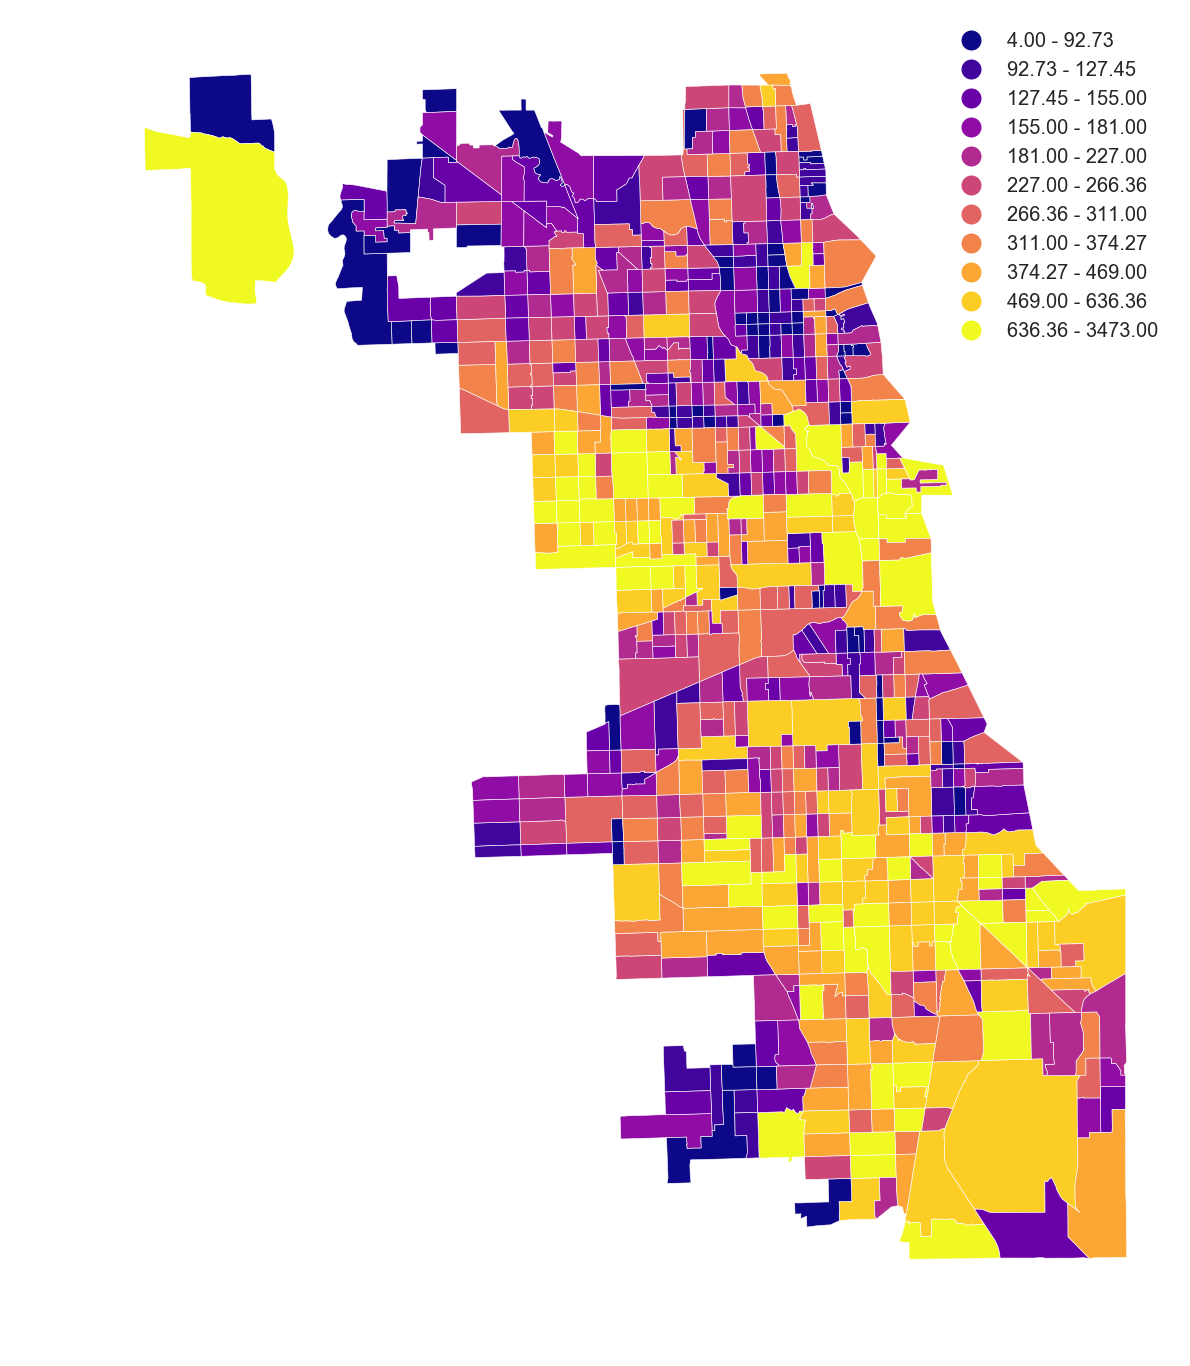

In [412]:
merged.plot(column = 'Count', cmap = 'plasma',
                                             scheme = 'quantiles', k = 11,
                                             edgecolor = 'white', legend = True,
                                             figsize = (12, 12)).set_axis_off()

In [369]:
merged['Population'] = pd.to_numeric(merged['B01001_001E'])

In [370]:
merged.head()

,statefp10,name10,commarea_n,namelsad10,commarea,geoid10,notes,tractce10,countyfp10,geometry,...,distance,id,Count,numeric,NAME,B01001_001E,state,county,tract,Population
0,17,8424,44,Census Tract 8424,44,17031842400,,842400,031,(POLYGON ((359011.0918414976 562381.5134188498...,...,188.562540,1064,1064,8424.0,"Census Tract 8424, Cook County, Illinois",3102,17,031,842400,3102
1,17,8403,59,Census Tract 8403,59,17031840300,,840300,031,(POLYGON ((353772.6046558226 572641.0855168948...,...,249.580478,234,234,8403.0,"Census Tract 8403, Cook County, Illinois",4025,17,031,840300,4025
2,17,8411,34,Census Tract 8411,34,17031841100,,841100,031,(POLYGON ((358458.7375946075 575992.5376885971...,...,316.925605,423,423,8411.0,"Census Tract 8411, Cook County, Illinois",7673,17,031,841100,7673
3,17,8412,31,Census Tract 8412,31,17031841200,,841200,031,(POLYGON ((353574.5667614859 576275.6182143808...,...,615.512418,349,349,8412.0,"Census Tract 8412, Cook County, Illinois",5651,17,031,841200,5651
4,17,8382,28,Census Tract 8382,28,17031838200,,838200,031,(POLYGON ((355245.5246228033 578342.4871348761...,...,449.379846,392,392,8382.0,"Census Tract 8382, Cook County, Illinois",1969,17,031,838200,1969


In [371]:
merged['Per Person'] = merged['Count'] / merged['Population']

There are three "inf" values in the column. So I plot it by removing those instances.

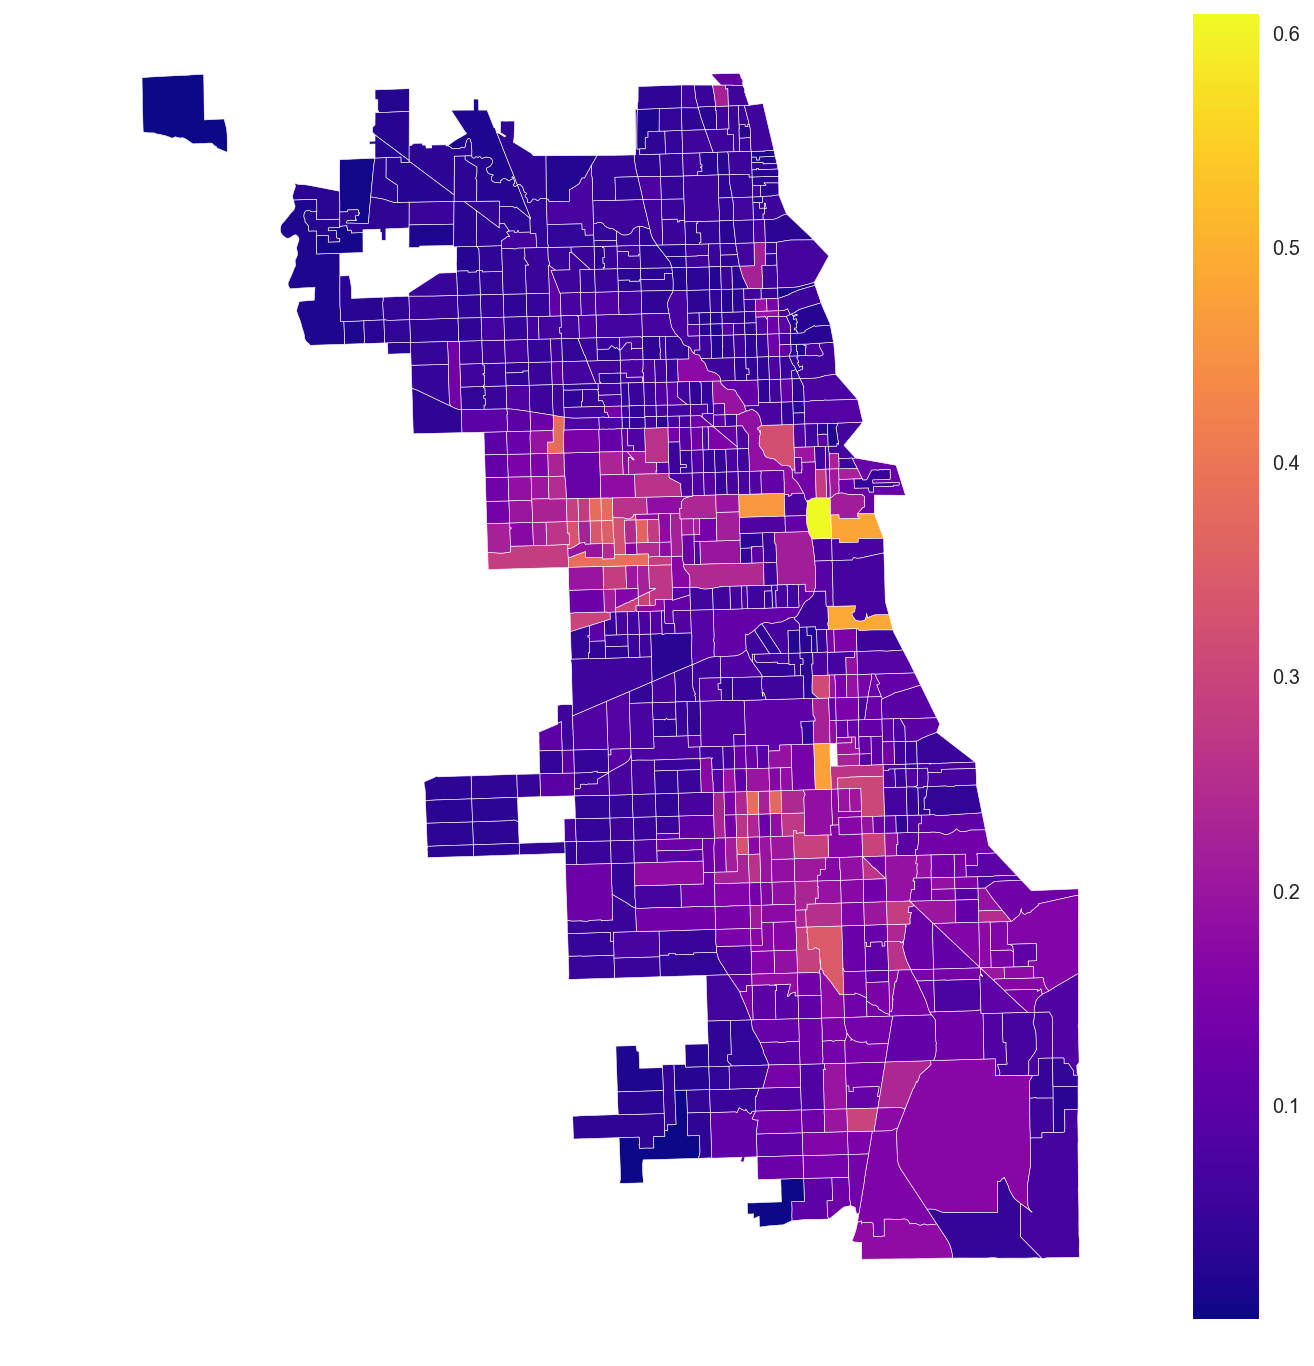

In [409]:
merged[~np.isinf(merged['Per Person'])].plot(column = 'Per Person', cmap = 'plasma', edgecolor = 'white', legend = True,
                                             figsize = (12, 12)).set_axis_off()

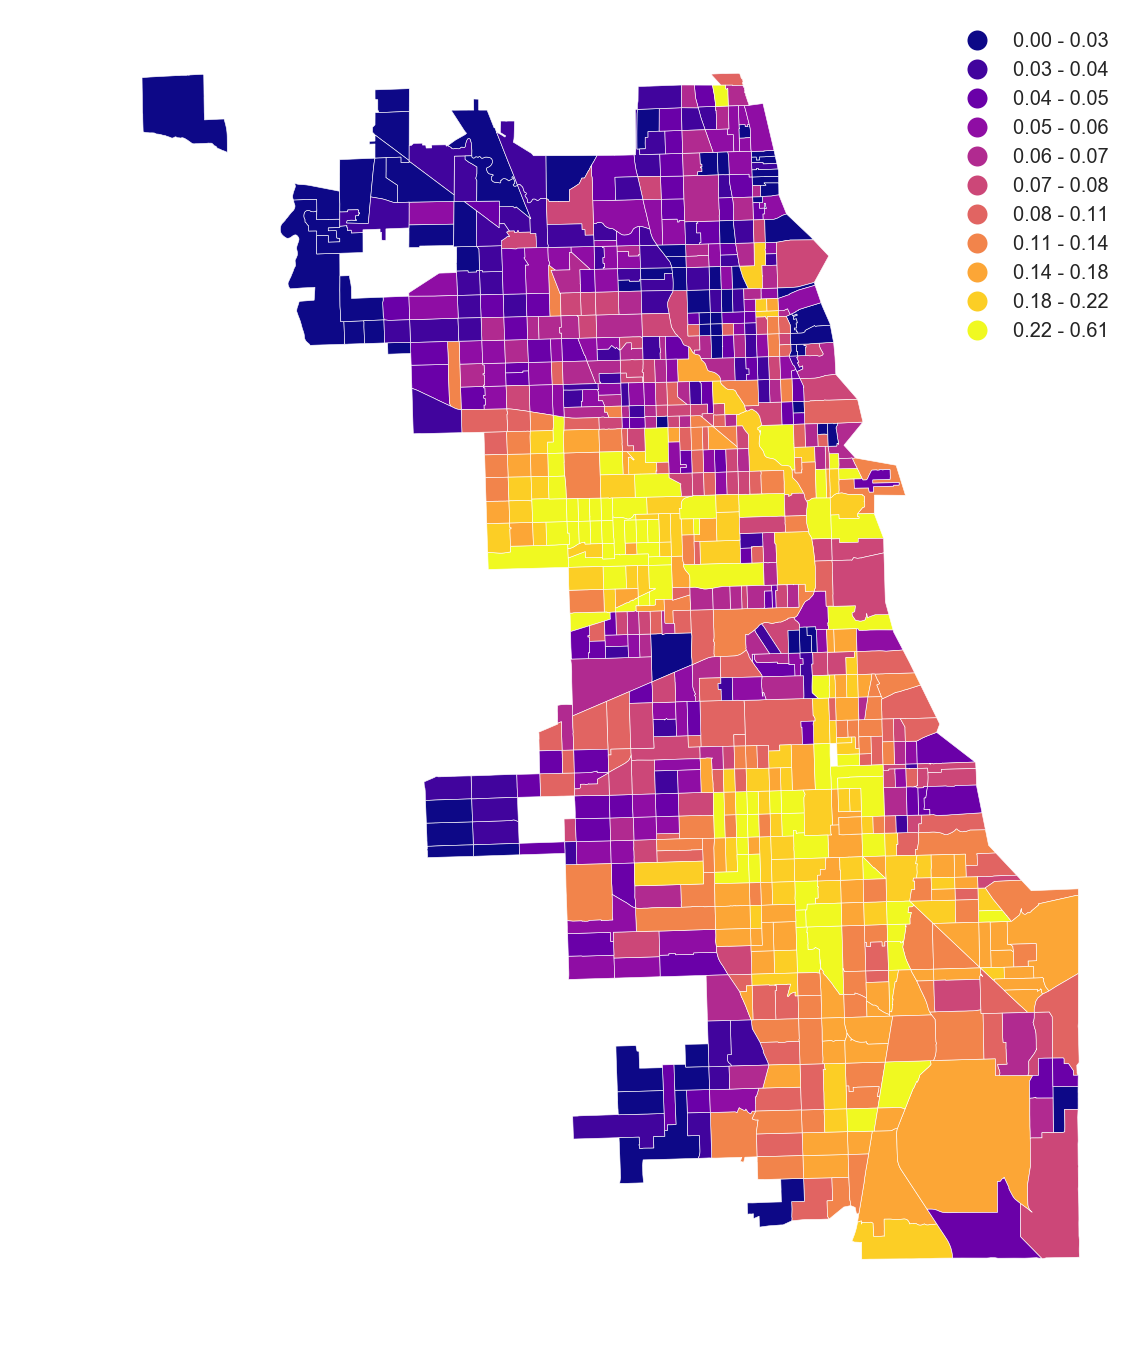

In [410]:
merged[~np.isinf(merged['Per Person'])].plot(column = 'Per Person', cmap = 'plasma',
                                             scheme = 'quantiles', k = 11,
                                             edgecolor = 'white', legend = True,
                                             figsize = (12, 12)).set_axis_off()

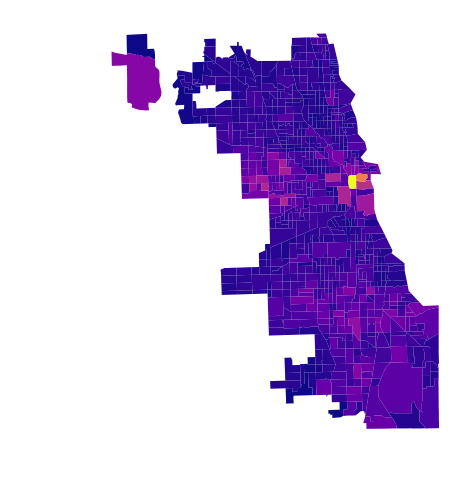

In [373]:
merged.plot(column = 'Count', cmap = 'plasma').set_axis_off()

In [374]:
merged[merged['name10']=='4107']

,statefp10,name10,commarea_n,namelsad10,commarea,geoid10,notes,tractce10,countyfp10,geometry,...,id,Count,numeric,NAME,B01001_001E,state,county,tract,Population,Per Person
498,17,4107,41,Census Tract 4107,41,17031410700,,410700,031,"(POLYGON ((361578.8926771602 569623.576855476,...",...,175,175,4107.0,"Census Tract 4107, Cook County, Illinois",2096,17,031,410700,2096,0.083492


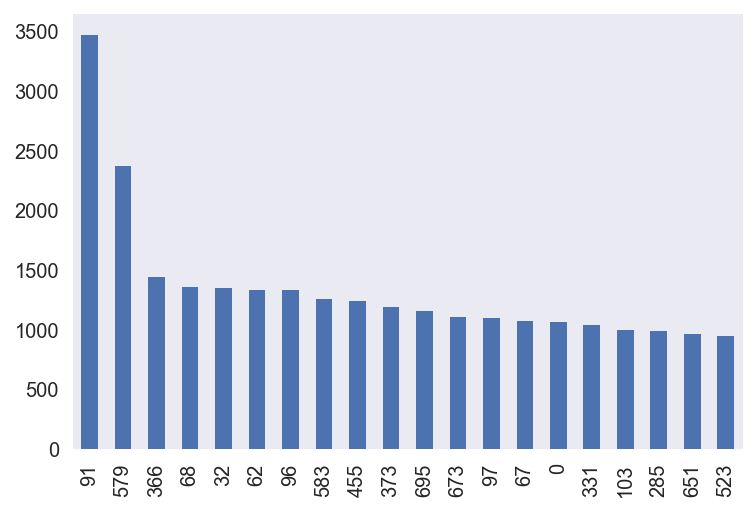

In [375]:
merged['Count'].sort_values(ascending = False).head(20).plot.bar()

In [376]:
merged.columns.values

array(['statefp10', 'name10', 'commarea_n', 'namelsad10', 'commarea',
       'geoid10', 'notes', 'tractce10', 'countyfp10', 'geometry',
       'park_area', 'distance', 'id', 'Count', 'numeric', 'NAME',
       'B01001_001E', 'state', 'county', 'tract', 'Population',
       'Per Person'], dtype=object)

In [377]:
merged.drop(['state', 'county', 'commarea_n', 'namelsad10', 'tractce10', 'countyfp10', 'statefp10', 'B01001_001E', 'tract', 'name10', 'notes'], axis = 1, inplace = True)

In [378]:
merged.head()

,commarea,geoid10,geometry,park_area,distance,id,Count,numeric,NAME,Population,Per Person
0,44,17031842400,(POLYGON ((359011.0918414976 562381.5134188498...,55851.593831,188.562540,1064,1064,8424.0,"Census Tract 8424, Cook County, Illinois",3102,0.343005
1,59,17031840300,(POLYGON ((353772.6046558226 572641.0855168948...,8148.527544,249.580478,234,234,8403.0,"Census Tract 8403, Cook County, Illinois",4025,0.058137
2,34,17031841100,(POLYGON ((358458.7375946075 575992.5376885971...,6642.280407,316.925605,423,423,8411.0,"Census Tract 8411, Cook County, Illinois",7673,0.055128
3,31,17031841200,(POLYGON ((353574.5667614859 576275.6182143808...,0.000000,615.512418,349,349,8412.0,"Census Tract 8412, Cook County, Illinois",5651,0.061759
4,28,17031838200,(POLYGON ((355245.5246228033 578342.4871348761...,3144.627241,449.379846,392,392,8382.0,"Census Tract 8382, Cook County, Illinois",1969,0.199086


Some basic regression statistics.

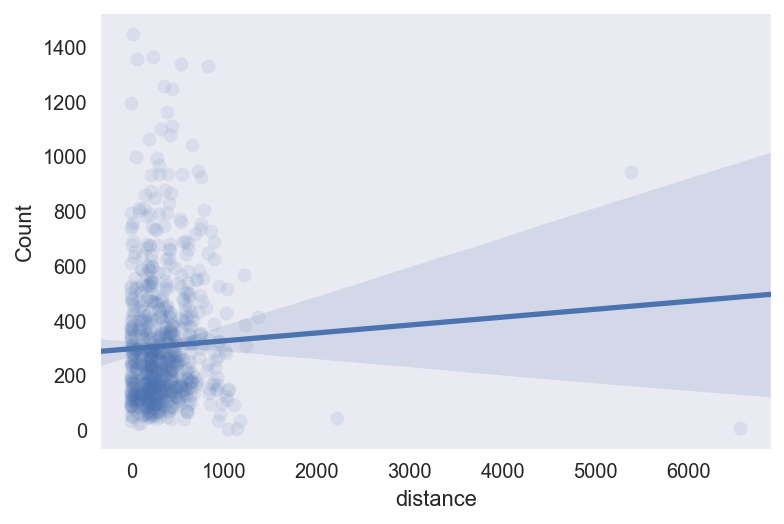

In [380]:
sns.regplot(x = 'distance', y = 'Count',
            data = merged[merged['Count']<1500], scatter_kws = {"alpha" : 0.1})

In [381]:
merged['distance'].sort_values(ascending = False).head()

169    6557.741178
667    5379.383879
129    2211.017616
786    1359.722557
182    1238.367514
Name: distance, dtype: float64

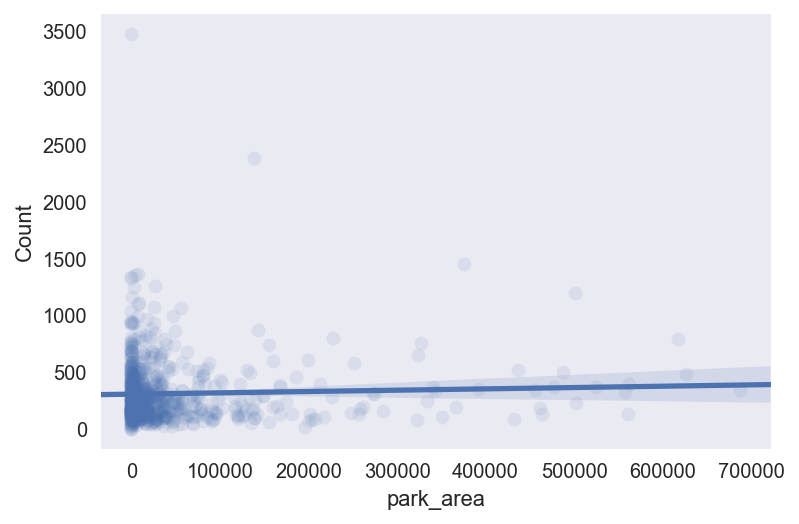

In [382]:
sns.regplot(x = 'park_area', y = 'Count',
            data = merged, scatter_kws = {"alpha" : 0.1})

In [383]:
ols = smf.ols(formula = 'Count ~ park_area + distance + Population',
             data = merged)

model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     31.70
Date:                Thu, 30 Nov 2017   Prob (F-statistic):           2.31e-19
Time:                        21:51:46   Log-Likelihood:                -5559.2
No. Observations:                 801   AIC:                         1.113e+04
Df Residuals:                     797   BIC:                         1.115e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    140.0037     20.903      6.698      0.000      98.973     181.035
park_area      0.0001      0.000      1.016      0.310   -9.67e-05       0.000
distance       0.0226      0.024      0.933      0.351      -0.025       0.070
Population     0.0469      0.005      9.530      0.000       0.037       0.057
==============================================================================
Omnibus:                      700.000   Durbin-Watson:                   1.514
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34146.672
Skew:                           3.672   Prob(JB):                         0.00
Kurtosis:                      34.132   Cond. No.                     2.36e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [384]:
addr = 'https://api.census.gov/data/2015/acs/acs5?get=NAME,B01001_001E,B01001_002E,B01002_001E,B02001_002E,B02001_003E,B02001_004E,B02001_005E,B06011_001E&for=tract:*&in=state:17&in=county:031'
resp = requests.get(addr)
json = resp.json()

In [385]:
census = pd.DataFrame(json, columns = json[0])

In [386]:
census = census.drop(0)

In [387]:
census.head()

,NAME,B01001_001E,B01001_002E,B01002_001E,B02001_002E,B02001_003E,B02001_004E,B02001_005E,B06011_001E,state,county,tract
1,"Census Tract 101, Cook County, Illinois",4106,1891,36.6,2186,1586,0,155,24860,17,031,010100
2,"Census Tract 102.01, Cook County, Illinois",7229,3554,31.8,3388,3295,26,223,21339,17,031,010201
3,"Census Tract 102.02, Cook County, Illinois",2304,1215,37.8,1178,674,12,185,20853,17,031,010202
4,"Census Tract 103, Cook County, Illinois",6077,3095,40.1,3478,1546,6,751,25278,17,031,010300
5,"Census Tract 104, Cook County, Illinois",5011,2067,25.4,3743,660,0,336,16476,17,031,010400


In [388]:
census.columns.values

array(['NAME', 'B01001_001E', 'B01001_002E', 'B01002_001E', 'B02001_002E',
       'B02001_003E', 'B02001_004E', 'B02001_005E', 'B06011_001E', 'state',
       'county', 'tract'], dtype=object)

In [389]:
census.rename(columns = {'B01001_001E': 'Total Population', 'B01001_002E': 'Male Population',
                         'B01002_001E': 'Median Age', 'B02001_002E': "White Population",
                         'B02001_003E': 'Black Population', 'B02001_004E': 'Native American Population',
                         'B02001_005E': 'Asian Population', 'B06011_001E': 'Median Income'}, inplace = True)

In [390]:
census.columns.values

array(['NAME', 'Total Population', 'Male Population', 'Median Age',
       'White Population', 'Black Population',
       'Native American Population', 'Asian Population', 'Median Income',
       'state', 'county', 'tract'], dtype=object)

In [391]:
census['Total Population'] = pd.to_numeric(census['Total Population'])
census['Male Population'] = pd.to_numeric(census['Male Population'])
census['Median Age'] = pd.to_numeric(census['Median Age'])
census['White Population'] = pd.to_numeric(census['White Population'])
census['Black Population'] = pd.to_numeric(census['Black Population'])
census['Native American Population'] = pd.to_numeric(census['Native American Population'])
census['Asian Population'] = pd.to_numeric(census['Asian Population'])
census['Median Income'] = pd.to_numeric(census['Median Income'])

In [392]:
census['Fraction Male'] = census['Male Population']/census['Total Population']
census['Fraction White'] = census['White Population']/census['Total Population']
census['Fraction Black'] = census['Black Population']/census['Total Population']
census['Fraction Native American'] = census['Native American Population']/census['Total Population']
census['Fraction Asian'] = census['Asian Population']/census['Total Population']

In [393]:
fullmerge = pd.merge(merged, census, how = 'left', left_on = 'NAME', right_on = 'NAME')

In [394]:
fullmerge = gpd.GeoDataFrame(fullmerge)

In [395]:
fullmerge.columns.values

array(['commarea', 'geoid10', 'geometry', 'park_area', 'distance', 'id',
       'Count', 'numeric', 'NAME', 'Population', 'Per Person',
       'Total Population', 'Male Population', 'Median Age',
       'White Population', 'Black Population',
       'Native American Population', 'Asian Population', 'Median Income',
       'state', 'county', 'tract', 'Fraction Male', 'Fraction White',
       'Fraction Black', 'Fraction Native American', 'Fraction Asian'], dtype=object)

In [396]:
ols = smf.ols(formula = 'Count ~ park_area + distance + Population + MP + WP + BP + NAP + AP + MI + FM + FW + FB + FNA + FA',
             data = fullmerge.rename(columns = {'Male Population': 'MP',
                                                'White Population': 'WP',
                                                'Black Population': 'BP',
                                                'Native American Population': 'NAP',
                                                'Asian Population': 'AP',
                                                'Median Income': 'MI',
                                                'Fraction Male': 'FM',
                                                'Fraction White': 'FW',
                                                'Fraction Black': 'FB',
                                                'Fraction Native American': 'FNA',
                                                'Fraction Asian': 'FA'}))

model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     27.13
Date:                Thu, 30 Nov 2017   Prob (F-statistic):           3.94e-53
Time:                        21:51:58   Log-Likelihood:                -3608.6
No. Observations:                 532   AIC:                             7247.
Df Residuals:                     517   BIC:                             7311.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    315.6457    302.876      1.042      0.298    -279.373     910.665
park_area     -0.0001      0.000     -0.941      0.347      -0.000       0.000
distance      -0.0222      0.028     -0.805      0.421      -0.076       0.032
Population    -0.1061      0.082     -1.297      0.195      -0.267       0.055
MP             0.1689      0.143      1.179      0.239      -0.113       0.450
WP             0.0876      0.044      2.002      0.046       0.002       0.173
BP             0.1459      0.038      3.817      0.000       0.071       0.221
NAP            0.6303      0.933      0.675      0.500      -1.203       2.464
AP             0.1985      0.065      3.032      0.003       0.070       0.327
MI             0.0033      0.001      3.597      0.000       0.001       0.005
FM            47.2534    496.210      0.095      0.924    -927.582    1022.089
FW          -529.8350    198.278     -2.672      0.008    -919.365    -140.305
FB          -220.6773    170.178     -1.297      0.195    -555.003     113.648
FNA         -404.9490   3144.023     -0.129      0.898   -6581.580    5771.682
FA          -809.1944    272.236     -2.972      0.003   -1344.018    -274.371
==============================================================================
Omnibus:                      648.518   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           103497.487
Skew:                           5.638   Prob(JB):                         0.00
Kurtosis:                      70.394   Cond. No.                     3.39e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.39e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [397]:
ols = smf.ols(formula = 'park_area ~ Population + FM + FW + FB + FNA + FA + np.log(MI)',
             data = fullmerge[fullmerge['Median Income']>0].rename(columns = {'Male Population': 'MP',
                                                'White Population': 'WP',
                                                'Black Population': 'BP',
                                                'Native American Population': 'NAP',
                                                'Asian Population': 'AP',
                                                'Median Income': 'MI',
                                                'Fraction Male': 'FM',
                                                'Fraction White': 'FW',
                                                'Fraction Black': 'FB',
                                                'Fraction Native American': 'FNA',
                                                'Fraction Asian': 'FA'}))

model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              park_area   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     4.950
Date:                Thu, 30 Nov 2017   Prob (F-statistic):           1.95e-05
Time:                        21:52:03   Log-Likelihood:                -6808.3
No. Observations:                 532   AIC:                         1.363e+04
Df Residuals:                     524   BIC:                         1.367e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.692e+04   1.18e+05      0.399      0.690   -1.84e+05    2.78e+05
Population    -0.5936      2.351     -0.253      0.801      -5.212       4.025
FM         -3.927e+05   9.87e+04     -3.980      0.000   -5.87e+05   -1.99e+05
FW         -6966.4986   3.72e+04     -0.187      0.851      -8e+04    6.61e+04
FB          4430.0842   3.05e+04      0.145      0.885   -5.55e+04    6.44e+04
FNA        -1.088e+05   5.48e+05     -0.198      0.843   -1.19e+06    9.68e+05
FA          1.802e+05   5.14e+04      3.508      0.000    7.93e+04    2.81e+05
np.log(MI)  1.782e+04   1.12e+04      1.588      0.113   -4225.496    3.99e+04
==============================================================================
Omnibus:                      423.686   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6157.845
Skew:                           3.543   Prob(JB):                         0.00
Kurtosis:                      18.086   Cond. No.                     5.39e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.39e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [398]:
ols = smf.ols(formula = 'distance ~ Population + FM + FW + FB + FNA + FA + np.log(MI)',
             data = fullmerge[fullmerge['Median Income']>0].rename(columns = {'Male Population': 'MP',
                                                'White Population': 'WP',
                                                'Black Population': 'BP',
                                                'Native American Population': 'NAP',
                                                'Asian Population': 'AP',
                                                'Median Income': 'MI',
                                                'Fraction Male': 'FM',
                                                'Fraction White': 'FW',
                                                'Fraction Black': 'FB',
                                                'Fraction Native American': 'FNA',
                                                'Fraction Asian': 'FA'}))

model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     3.264
Date:                Thu, 30 Nov 2017   Prob (F-statistic):            0.00211
Time:                        21:52:03   Log-Likelihood:                -3881.8
No. Observations:                 532   AIC:                             7780.
Df Residuals:                     524   BIC:                             7814.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    539.4728    480.502      1.123      0.262    -404.474    1483.420
Population     0.0266      0.010      2.771      0.006       0.008       0.045
FM           315.6505    402.847      0.784      0.434    -475.744    1107.045
FW          -193.4593    151.835     -1.274      0.203    -491.739     104.820
FB          -184.6961    124.595     -1.482      0.139    -429.463      60.071
FNA        -1832.6158   2238.086     -0.819      0.413   -6229.339    2564.107
FA          -680.9729    209.738     -3.247      0.001   -1093.004    -268.942
np.log(MI)   -25.9389     45.818     -0.566      0.572    -115.949      64.071
==============================================================================
Omnibus:                      899.166   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           619380.093
Skew:                           9.965   Prob(JB):                         0.00
Kurtosis:                     168.966   Cond. No.                     5.39e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.39e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [399]:
trimmed = fullmerge[fullmerge['distance']<1500]

In [400]:
trimmed = trimmed[trimmed['Median Income']>0]

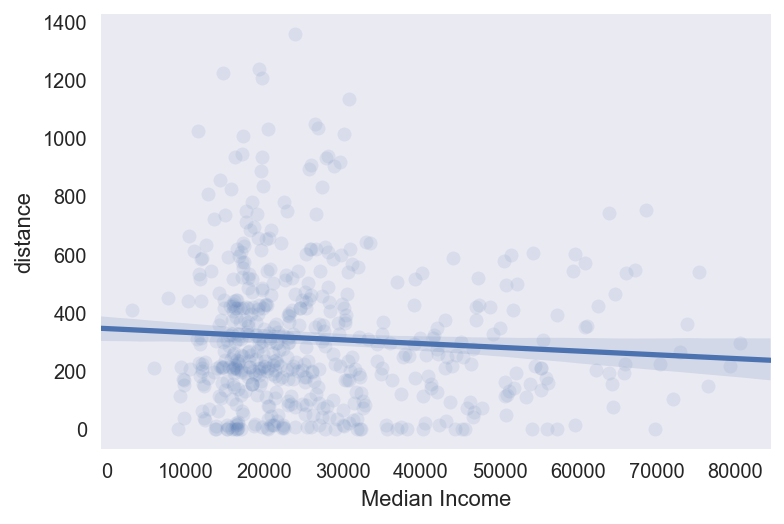

In [401]:
sns.regplot(x = 'Median Income', y = 'distance',
                       data = trimmed, scatter_kws = {"alpha" : 0.1})

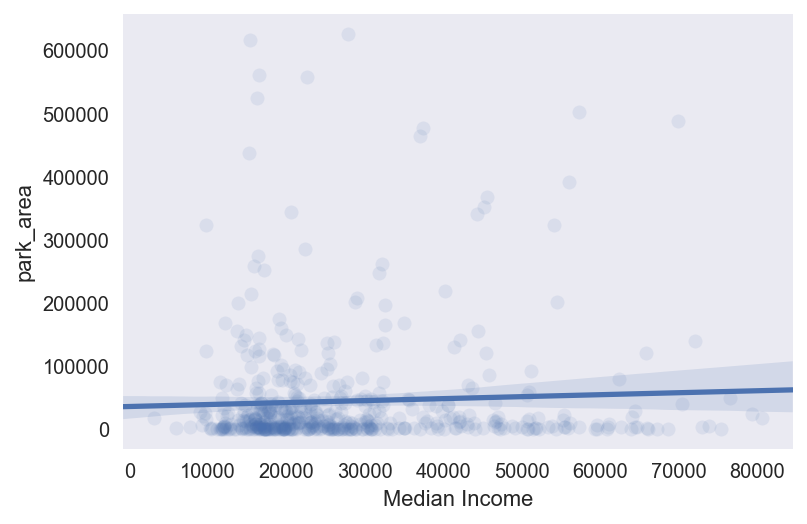

In [402]:
sns.regplot(x = 'Median Income', y = 'park_area',
                       data = trimmed, scatter_kws = {"alpha" : 0.1})

# New York City

We repeat the process for New York City. NYC had 478804 offenses in 2016, so we place a limit on on SoQL call of 500000

In [ ]:
soql = "https://data.cityofnewyork.us/resource/9s4h-37hy.json?$query="
soql += quote("SELECT cmplnt_num,  addr_pct_cd, ofns_desc ")
soql += quote("WHERE date_trunc_y(rpt_dt) = '2016-01-01T00:00:00.000' ")
soql += quote("LIMIT 500000")

resp = requests.get(soql).json()
NYC_crime = pd.DataFrame(resp)
NYC_pre_count = NYC_crime.groupby("addr_pct_cd").count()

In [ ]:
NYC_pre_count.reset_index(inplace = True)

In [ ]:
NYC_pre_count.sort_values('addr_pct_cd', inplace = True)

In [ ]:
NYC_pre_count.set_index('addr_pct_cd')
NYC_pre_count.reset_index(inplace = True)
NYC_pre_count.drop('index', axis = 1, inplace = True)

In [ ]:
soql = "https://data.cityofnewyork.us/resource/kmub-vria.json?$query="
soql += quote("SELECT precinct, the_geom ")
soql += quote("LIMIT 500")

resp = requests.get(soql).json()

In [ ]:
data = resp
for d in data:
    d['the_geom'] = shape(d['the_geom'])

NYC_precincts = gpd.GeoDataFrame(data).set_geometry('the_geom')
NYC_precincts.crs = {'init' :'epsg:2260'}
NYC_precincts.head()

In [ ]:
NYC_precincts["precinct"][0]
NYC_pre_count['addr_pct_cd'][0]

In [ ]:
NYC_precincts = NYC_precincts.merge(NYC_pre_count, left_on = 'precinct', right_on = 'addr_pct_cd')

In [ ]:
PreMap = NYC_precincts.to_crs(epsg = 2260).plot(column = 'cmplnt_num', scheme = 'equal_interval', k = 11, cmap = 'plasma', legend=True,
                           linewidth = 1, edgecolor = 'black', figsize = (9,5))
PreMap.set_title("Crimes per precinct in New York City (2016)", fontsize = 20)
PreMap.set_axis_off()

PreMap.get_legend().set_bbox_to_anchor((1.35, .65))
PreMap.get_legend().get_frame().set_linewidth(0)

In [ ]:
NYC_precincts[['precinct', 'cmplnt_num']].sort_values('cmplnt_num', ascending = False).head(20).plot.bar('precinct')

Will take some time, but can combine census block data with geographical files to find population per precinct.

# Boston

In [ ]:
Boston_crime = pd.read_csv("Boston_crime.csv", usecols = ['OFFENSE_CODE', 'DISTRICT'])

In [ ]:
Boston_crime.dropna(inplace = True)

In [ ]:
Boston_crime = Boston_crime.groupby('DISTRICT').count()

In [ ]:
Boston = gpd.read_file('./Police_Districts/Police_Districts.shp')

In [ ]:
BostonMerge = Boston.merge(Boston_crime, left_on='DISTRICT', right_index=True)

In [ ]:
BoMap = BostonMerge.to_crs(epsg=2249).plot(column = 'OFFENSE_CODE', scheme = 'equal_interval', k = 11, cmap = 'plasma',
                                           legend=True, linewidth = 1, edgecolor = 'black', figsize = (9, 5))
BoMap.set_title("Crimes per district in Boston (2016)", fontsize = 20)
BoMap.set_axis_off()

BoMap.get_legend().set_bbox_to_anchor((1.45, .65))

# Philadelphia

In [ ]:
sql = "https://phl.carto.com/api/v2/sql?q="
sql += quote("SELECT * ")
sql += quote('FROM incidents_part1_part2 ')
sql += quote("WHERE dispatch_date LIKE '2016-%' ")
sql += quote("LIMIT 200000")

resp = requests.get(sql).json()

In [ ]:
resp.keys()

In [ ]:
Philly = pd.DataFrame.from_dict(resp['rows'])

In [ ]:
Philly_count = Philly.groupby('dc_dist').count()["psa"]

In [ ]:
Philly_count = pd.DataFrame(Philly_count)

In [ ]:
Philly_PD = gpd.read_file("./Boundaries_District/Boundaries_District.shp")

In [ ]:
Philly_PD.head()

In [ ]:
Philly_merge = pd.merge(Philly_PD, Philly_count, left_on = "DIST_NUMC", right_index = True)

In [ ]:
Philly_merge.head()

In [ ]:
PhillyMap = Philly_merge.to_crs(epsg=2824).plot(column = 'psa', scheme = 'equal_interval', k = 10, cmap = 'plasma',
                                           legend=True, linewidth = 1, edgecolor = 'black', figsize = (9, 5))
PhillyMap.set_title("Crimes per district in Philadelphia (2016)", fontsize = 20)
PhillyMap.set_axis_off()

PhillyMap.get_legend().set_bbox_to_anchor((1.45, .65))

# San Francisco

In [ ]:
soql = "https://data.sfgov.org/resource/cuks-n6tp.json?$query="
soql += quote("SELECT COUNT(*),  ")
soql += quote("WHERE date_trunc_y(date) = '2016-01-01T00:00:00.000' ")
soql += quote("LIMIT 300000")

resp = requests.get(soql).json()
SF_crime = pd.DataFrame(resp)
SF_crime_count = SF_crime.groupby('pddistrict').count()

In [ ]:
SF_crime_count = SF_crime.groupby('pddistrict').count()['incidntnum']

In [ ]:
SF_crime_count = pd.DataFrame(SF_crime_count)

In [ ]:
soql = "https://data.sfgov.org/resource/q52f-skbd.json?$query="
soql += quote("SELECT district, the_geom ")
soql += quote("LIMIT 500")

resp = requests.get(soql).json()

In [ ]:
data = resp
for d in data:
    d['the_geom'] = shape(d['the_geom'])

SF_precincts = gpd.GeoDataFrame(data).set_geometry('the_geom')
SF_precincts.head()

In [ ]:
SF_crime.head()

In [ ]:
SF_merge = pd.merge(SF_precincts, SF_crime_count, left_on = 'district', right_index = True)

In [ ]:
SFMap = SF_merge.plot(column = 'incidntnum', scheme = "equal_interval", k = 11, cmap = 'plasma', legend=True,
             linewidth = 2, edgecolor = "black", figsize = (9, 5))

SFMap.set_title("Crime per police district in San Francisco (2016)", fontsize = 20)
SFMap.set_axis_off()
SFMap.get_legend().set_bbox_to_anchor((1.35, .65))
SFMap.get_legend().get_frame().set_linewidth(0)

In [ ]:
SF_merge.head()